## Семинар 3 "Определение ключевых точек лица"

## Задание

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица. 

Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.

Для **зачета** дз нужно сделать одно из двух:

1. Исследовать 6 разных архитектур и написать подробный вывод + мысли почему одна сеть работает лучше чем другая (разные функции активации, глубины сетей, размеры и типы слоев)
2. Преодолеть порог MSE=8 на тесте


Также до  21 октября 23:59 можно получить до 5 дополнительных баллов за лучшее решение. (За первое место 5 баллов, за второе — 3 балла, за третье — 1 балла.)

Для решения можно пользоваться всем инструментарием, с которым мы познакомимся:  предобученные модели, сверточные сети, любые оптимизаторы, batchnorm, dropout, etc.

In [1]:
!pip install pytorch-ignite

     |████████████████████████████████| 175 kB 759 kB/s eta 0:00:01


In [5]:
%matplotlib inline
import os
import torch
import sys
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh, L1Loss, Module, Parameter
from torch.autograd import Variable
# Ignore warnings
import warnings
from torch.autograd import Variable
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
from torch import nn


try:
    from tensorboardX import SummaryWriter
except ImportError:
    raise RuntimeError("No tensorboardX package is found. Please install with the command: \npip install tensorboardX")

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss




Image name: 2065.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 2. 39.]
 [ 3. 51.]
 [ 4. 62.]
 [ 5. 73.]]


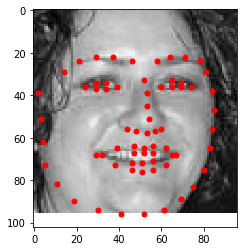

In [14]:
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv('dataset/train/face_landmarks.csv')

n = 1090
img_name = landmarks_frame.values[n, 0]
landmarks = landmarks_frame.values[n, 1:].astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=100, marker='.', c='red', cmap='rgb')
    plt.pause(0.001)  

plt.figure()
show_landmarks(io.imread(os.path.join('dataset/train/', img_name)),
               landmarks)
plt.show()

In [22]:
x = np.zeros((3, 5, 2), dtype=np.complex128)

In [26]:
np.size(x)

30

In [27]:
def show_landmarks_batch(sample_batch, y_pred=None):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batch
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    print(images_batch.numpy().shape)
    plt.imshow(grid.numpy().transpose(1,0,2).reshape(im_size, -1), cmap="gray")

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r', label='Real')

    if type(y_pred) != type(None):
        for i in range(batch_size):
            plt.scatter(y_pred[i, :, 0] + i * im_size,
                        y_pred[i, :, 1],
                        s=10, marker='.', c='b',  label='Prediction')
        plt.title('Batch from dataloader')
    plt.legend()

In [29]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [30]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return image, landmarks




class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        return {'image':  torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}
class ToTensor2(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        return {'image':  torch.from_numpy(image+np.random.randn(96*96).reshape(96, 96)*0.32),
                'landmarks': torch.from_numpy(landmarks)}

In [31]:
train_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                     root_dir='dataset/train',
                                     transform=ToTensor2()
                                     )

test_dataset = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                     root_dir='dataset/test',
                                     transform=ToTensor()
                                     )

In [32]:
def get_data_loaders(train_batch_size=64, val_batch_size=64):

    train_loader = DataLoader(
        train_dataset, batch_size=train_batch_size, shuffle=True
    )

    test_loader = DataLoader(
        test_dataset, batch_size=val_batch_size, shuffle=False
    )

    return train_loader, test_loader

In [33]:
class Net(Module):
    def __init__(self, activation=Sigmoid(), latent_size=200):
        super().__init__()
        self.fc1 =Linear(96 * 96, 200)
        self.fc2 = Linear(200, 68 * 2)
        self.activation = activation
    def forward(self, x):
        return self.fc2(self.activation(self.fc1(x.view(x.shape[0], -1)))).view(x.shape[0], 68, 2)

In [39]:
network = Net()
train_dataloader, test_dataloader = get_data_loaders()
writer = SummaryWriter(filename_suffix='first', logdir="out_logs")

device = "cpu"

if torch.cuda.is_available():
    device = "cuda"
criterion = MSELoss()
optim = torch.optim.Adam
learning_rate = 0.01
max_epochs = 10

optimizer = optim(network.parameters(), lr=learning_rate)

trainer = create_supervised_trainer(network, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(
    network, metrics={"L2 loss": Loss(criterion), "L1 loss": Loss(L1Loss())}, device=device
)

training_history = {'l1':[],'l2':[]}
validation_history = {'l1':[],'l2':[]}
last_epoch = []

In [40]:
@trainer.on(Events.ITERATION_COMPLETED(every=10))
def log_training_loss(engine):
    writer.add_scalar("training/loss", engine.state.output, engine.state.iteration)
    writer.flush()


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_dataloader)
    metrics = evaluator.state.metrics
    l2_train = metrics["L2 loss"]
    l1_train = metrics['L1 loss']
    last_epoch.append(0)
    training_history['l2'].append(l2_train)
    training_history['l1'].append(l1_train)
    writer.add_scalar("training/epoch_loss", l2_train, trainer.state.epoch)
    
    evaluator.run(test_dataloader)
    metrics = evaluator.state.metrics
    l2 = metrics["L2 loss"]
    l1 = metrics['L1 loss']
    validation_history['l2'].append(l2)
    validation_history['l1'].append(l1)
    
    writer.add_scalar("validation/epoch_loss", l2, trainer.state.epoch)
    writer.flush()
    
    sys.stdout.write("\rTraining/Validation Results - Epoch: {}  Avg MSE: {:.2f} / {:.2f} Avg MAE: {:.2f} / {:.2f}"
          .format(trainer.state.epoch, l2_train, l2, l1_train, l1))
   

In [41]:
trainer.run(train_dataloader, max_epochs=2)

Training/Validation Results - Epoch: 2  Avg MSE: 17.55 / 18.55 Avg MAE: 2.98 / 3.05

State:
	iteration: 196
	epoch: 2
	epoch_length: 98
	max_epochs: 2
	output: 10.52239990234375
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

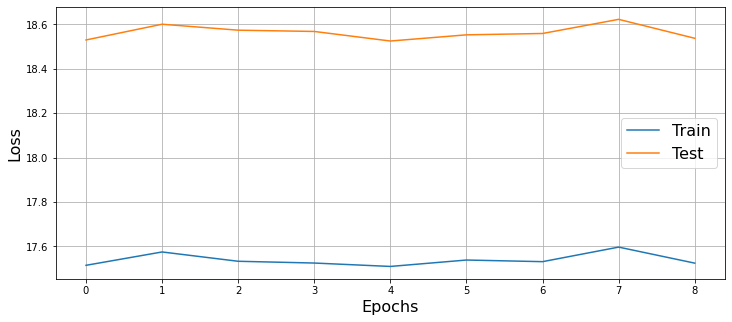

In [54]:
plt.figure(figsize=(12, 5))
plt.plot(training_history['l2'][1:], label='Train')
plt.plot(validation_history['l2'][1:], label='Test')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()

(2, 96, 96)


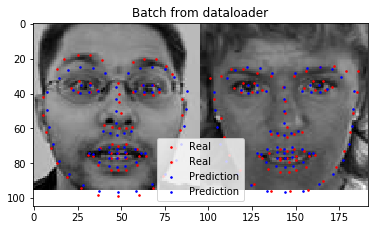

In [43]:
_, test_dataloader = get_data_loaders(val_batch_size=2)

images_batch = next(iter(test_dataloader))
x, y = images_batch
y_pred = network(x)
y_pred = y_pred.data.numpy()
show_landmarks_batch(images_batch, y_pred)

In [12]:
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

In [76]:
writer = SummaryWriter("out_logs/exp2")

In [57]:
for x,y in train_dataloader:
    break

In [79]:
writer.add_graph(network, x)
writer.flush()

In [87]:
# Будем использовать первый слой сети в качестве feature extractor
# с помощью writer.add_embedding визуализируем полученные признаки
# резульат появится во вкладке PROJECTOR
_, test_dataloader = get_data_loaders(val_batch_size=20)

images_batch = next(iter(test_dataloader))




embedder = list(network.modules())[1]

features = embedder(images_batch[0].view(images_batch[0].shape[0], -1))
writer.add_embedding(features,global_step=2)
writer.flush()

# Links

[Официальная страница ignite](https://pytorch.org/ignite/index.html)

[Официальная страница PyTorch Lightning](https://github.com/PyTorchLightning/pytorch-lightning)




In [ ]:
landmarks_frame = pd.read_csv('dataset/train/face_landmarks.csv')
train_dataloader = DataLoader(train_dataset, batch_size=64,
                        shuffle=True, num_workers=7)

test_dataloader = DataLoader(test_dataset, batch_size=64,
                        shuffle=True,num_workers=7)

In [ ]:
dtype=torch.FloatTensor

def train(network, epochs, learning_rate, loss=MSELoss(), optim=torch.optim.Adam):
    train_loss_epochs = []
    test_loss_epochs = []
    optimizer = optim(network.parameters(), lr=learning_rate)
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for sample in train_dataloader:
                X = sample['image']
                X = X.view(X.shape[0],1,96,96).type(dtype)
                y = sample['landmarks']
                y = y.view(y.shape[0], -1).type(dtype)
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()
  
            train_loss_epochs.append(np.mean(losses))
            losses = []    
            for sample in test_dataloader:
                X = sample['image']
                X = X.view(X.shape[0],1,96,96).type(dtype)
                #X = X.view(X.shape[0], -1).type(dtype)
                y = sample['landmarks']
                y = y.view(y.shape[0], -1).type(dtype)
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                
            test_loss_epochs.append(np.mean(losses))
            print('\rEpoch {0}... (Train/Test) MSE: {1:.3f}/{2:.3f}'.format(
                epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, test_loss_epochs
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal(layer.weight)
channels = 1

In [ ]:
class Net(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, (4,4), padding=(2,2)), nn.ReLU(),
                                        nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, (4,4), padding=(2,2)), nn.ReLU(),
                                         nn.MaxPool2d(2),
                                        nn.Conv2d(16, 32, (4,4), padding=(2,2)),nn.ReLU(),
                                        nn.MaxPool2d(2),
                                        nn.Conv2d(32, 64, (4,4), padding=1),nn.ReLU(),
                                        nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(nn.Linear(40*40, 400),
                                           nn.BatchNorm1d(400),
                                           nn.ReLU(),nn.Linear(400, 200),nn.ReLU(),
                                           nn.BatchNorm1d(200),
                                          nn.Linear(200, 2*68))
        self.linear_layers.apply(init_weights)
        

    def forward(self, x):
        #print(x.shape)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        #print(x.shape)
        return x

In [5]:
network = Net(image_size=96)
train_data_epochs = train(network, 200, 0.01)

Epoch 0... (Train/Test) MSE: 1024.567/18.951
Epoch 1... (Train/Test) MSE: 16.507/20.138
Epoch 2... (Train/Test) MSE: 14.457/14.589
Epoch 3... (Train/Test) MSE: 12.165/12.560
Epoch 4... (Train/Test) MSE: 10.169/10.351
Epoch 5... (Train/Test) MSE: 8.809/9.249
Epoch 6... (Train/Test) MSE: 7.776/8.184
Epoch 7... (Train/Test) MSE: 6.961/7.267
Epoch 8... (Train/Test) MSE: 6.212/6.949
Epoch 9... (Train/Test) MSE: 5.808/6.196
Epoch 10... (Train/Test) MSE: 5.028/6.151
Epoch 11... (Train/Test) MSE: 4.725/5.965
Epoch 12... (Train/Test) MSE: 4.620/5.799
Epoch 13... (Train/Test) MSE: 4.633/5.775
Epoch 14... (Train/Test) MSE: 4.356/5.971
Epoch 15... (Train/Test) MSE: 4.015/5.727
Epoch 16... (Train/Test) MSE: 3.871/5.229
Epoch 17... (Train/Test) MSE: 3.769/5.227
Epoch 18... (Train/Test) MSE: 3.589/5.139
Epoch 19... (Train/Test) MSE: 3.441/5.060
Epoch 20... (Train/Test) MSE: 3.497/5.167
Epoch 21... (Train/Test) MSE: 3.175/5.047
Epoch 22... (Train/Test) MSE: 3.211/5.003
Epoch 23... (Train/Test) MSE: 3.

Epoch 193... (Train/Test) MSE: 1.353/4.891
Epoch 194... (Train/Test) MSE: 1.350/5.020
Epoch 195... (Train/Test) MSE: 1.237/4.377
Epoch 196... (Train/Test) MSE: 1.175/4.542
Epoch 197... (Train/Test) MSE: 1.306/4.480
Epoch 198... (Train/Test) MSE: 1.360/4.370
Epoch 199... (Train/Test) MSE: 1.275/4.482


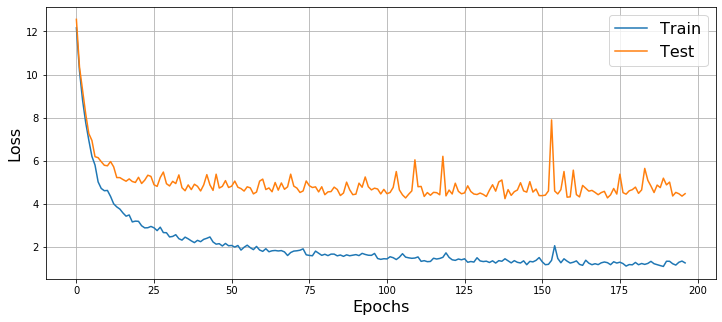

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(train_data_epochs[0][3:], label='Train')
plt.plot(train_data_epochs[1][3:], label='Test')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()

In [9]:
np.min(train_data_epochs[1][3:])

4.252145938873291